# IO ECO 7408: Problem Set 2 – Aggregate Logit Demand Estimation for Soda
## Instructor: Prof. Douglas Turner
## TA: Qinling Zhang
## Student: C.H.

In [1]:
import numpy as np
import pandas as pd
import pyblp

import sys
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize

from IPython.display import Image, display

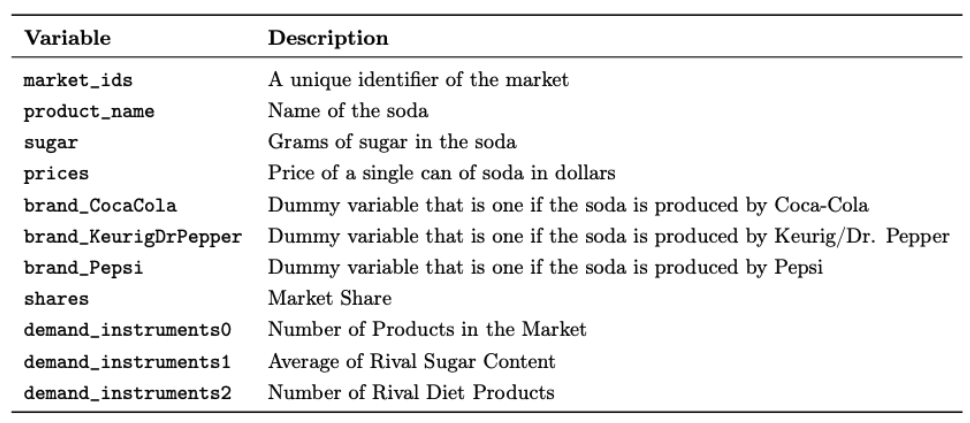

In [2]:
display(Image(filename="/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/2.1.png"))

and caffeine

## 1. Data Setup and Variable Construction

### (a) Load the dataset into Python using pandas. Print the first few rows to inspect the data.

In [3]:
df = pd.read_csv('/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/data/soda_data.csv')

print(df.head(5))

   market_ids   product_name           brand  sugar  caffeine  prices  \
0           0      Dr Pepper  KeurigDrPepper     40        41    1.98   
1           0  A&W Root Beer  KeurigDrPepper     45         0    2.11   
2           0           Coke        CocaCola     39        34    1.98   
3           0         Sprite        CocaCola     38         0    2.11   
4           0      Pepsi Max         PepsiCo      0        42    1.54   

   brand_CocaCola  brand_KeurigDrPepper  brand_PepsiCo    shares  \
0           False                  True          False  0.021576   
1           False                  True          False  0.012189   
2            True                 False          False  0.020021   
3            True                 False          False  0.012548   
4           False                 False           True  0.088813   

   demand_instruments0  demand_instruments1  demand_instruments2  
0                   10                 20.1                    5  
1                 

### (b) Explain intuitively why each demand instrument is likely valid. (Hint: Two conditions need to be met for each instrument.)

For instrument validity, we need to check two conditions:

A. Relevence: The instrument must be correlated with the endogenous variable (price p) after controlling for oversrvable characteristcis and fixed effects. Formally, Cov(Z, p | X, FE) ≠ 0.

B. Exclusion Restriction: The instrument must be uncorrelated with the demand error ξ (which captures quality/preference, unobserved factors entering the regression residual) and only affect demand through price. Formally, Cov(Z, ξ | X, FE) = 0, and Z does not enter the utility directly.

Now lets go through each instrument one by one.

1) demand_instruments0 (Number of Products in the Marker)
   
   For A: Number of Products in the Marker is corredlated with price, since more products, severer competition, lower price.

   For B: Number of Products in the Marker doesnt directly affect the utility of a specific product ( doesnt related to the error term ξ).

2) demand_instruments1 (Average of Rival' Sugar Content)
   
    For A: Average of Competitors' Sugar Content is correlated with price, since more sugar content of rival's products, more/lower price of the product.

    For B: Average of Competitors' Sugar Content doesnt directly affect the utility of a specific product ( doesnt related to the error term ξ).

3) demand_instruments2 (Number of Rival Diet Products)
   
    For A: Number of Rival Diet Products is correlated with price, since more diet products, severer competition, lower price. (Or, higher demand of the product, higher price of the product.)
    
    For B: Number of Rival Diet Products doesnt directly affect the utility of a specific product ( doesnt related to the error term ξ).

## 2. Estimating the Logit Model using Pyblp

### (a) Consider the following utility function

where i denotes individuals, j denotes the product and t denotes the market. What variables are
contained in ξ_jt? 

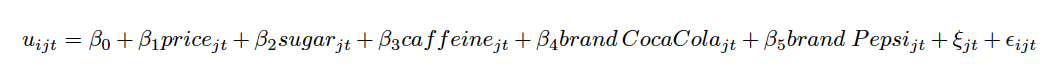

In [4]:
display(Image(filename="/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/2.2.png"))

ξ_jt are the unobserved product characteristics that affect consumer utility but are not captured by the observed variables in the model. These could include factors such as brand taste, bottle size(fl oz) that influence consumer choice and related to price but are not directly measured in the dataset.

### (b) Could the variable brand KeurigDrPepperjt be included in the above utility function?

No, i dont think so. Because we already have added two brand dummies (Cocacola and Pepsi) in the utility funciton. With an intercept, you must omit one brand to avoid perfect multicollinearity (dummy-variable trap).

This interception means: the average utility of the omitted brand (KeurigDrPepper) when all other variables are zero.

### (c) How would you interpret the coefficient β4?

It measures the mean-utility premium of Coca-Cola relative to Keurig Dr Pepper, holding price, sugar, caffeine, etc. fixed.

### (d) Using the pyblp package, estimate a logit demand model based on the above utility function.

In [5]:
#simple (agg market share) logit
logit_formulation = pyblp.Formulation(
    "1+ prices + sugar + caffeine + brand_CocaCola + brand_PepsiCo" 
)



problem_logit = pyblp.Problem( # yblp.Problem(formulation, product_data)：构造一个估计问题对象。
    logit_formulation,
    df)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N    K1    MD 
---  ---  ----  ----
52   504   6     8  

Formulations:
     Column Indices:         0     1       2       3               4                     5         
--------------------------  ---  ------  -----  --------  --------------------  -------------------
X1: Linear Characteristics   1   prices  sugar  caffeine  brand_CocaCola[True]  brand_PepsiCo[True]


# why no F from the result?

In [6]:
#estimate logit
results_logit = problem_logit.solve()

Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 1    +2.588593E+00     0      +2.168747E+06      +1.509672E+08  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  ----------------  -----------------
 2    +2.985336E-01     0      +2.026217E+06      +1.520486E+08  

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
       1             prices            sugar          caffeine      brand_CocaCola[True]  brand

### (e) What is the ranking of brands in terms of utility?

DrPepper > CocaCola > PepsiCo

### (f) 1. How much does a one milligram reduction in Caffeine increase mean utility? 

Since esitmate of β_caffecine is -1.286156E-01. Decreasing caffeine by 1 mg increases mean utility by 0.1286156, holding other variables constant.


###   (f) 2. Why don’t firms always wish to reduce caffeine content in all sodas? (Hint: The answer may reveal a flaw in this demand system.)

1. Since there still exist some consumers who prefer caffeinated sodas, which related to heterogeneous preference. And this model is a simple logit model, which assumes homogeneous preference, which is a flaw in this demand system.

2. In addition, there might be a other reasion: the content of caffeine might be related to other product characteristics, such as brand image, taste, etc. Reducing caffeine content might negatively impact these other characteristics, leading to a decrease in overall utility for some consumers.

## 3. Analyzing Logit Demand Elasticities

### (a) Calculate the demand elasticity matrix for market 0 (i.e., the market with a market_id of 0).

In [7]:
#compute elasticities
elasticities_logit = results_logit.compute_elasticities(market_id=0)


names = df[df['market_ids'] == 0]['product_name'].tolist()
# .tolist()  make [pandas series] to ]python list]
# names = 'Dr Pepper', 'A&W Root Beer', 'Coke', 'Sprite', 'Pepsi Max',...

elasticities_logit = pd.DataFrame(elasticities_logit, index=names, columns=names)

print(elasticities_logit.shape)
print(elasticities_logit.iloc[:5, :5])


Computing elasticities with respect to prices ...
Finished after 00:00:00.

(11, 11)
               Dr Pepper  A&W Root Beer       Coke     Sprite  Pepsi Max
Dr Pepper     -56.316630       0.747665   1.152407   0.769686   3.975964
A&W Root Beer   1.241891     -60.589952   1.152407   0.769686   3.975964
Coke            1.241891       0.747665 -56.406114   0.769686   3.975964
Sprite          1.241891       0.747665   1.152407 -60.567930   3.975964
Pepsi Max       1.241891       0.747665   1.152407   0.769686 -40.791775


### (b) Which product has the largest own-price elasticity (in absolute value)? Provide the name of the soda.

In [8]:
print("Logit Own-price Elasticities:")
print(names)

np.diag(elasticities_logit)[:11]

Logit Own-price Elasticities:
['Dr Pepper', 'A&W Root Beer', 'Coke', 'Sprite', 'Pepsi Max', 'Diet 7UP', 'Diet Coke', 'Coke Zero', 'Diet Pepsi', 'Pepsi', '7UP']


array([-56.31663012, -60.58995153, -56.40611446, -60.56793001,
       -40.79177509, -47.193028  , -38.13398917, -42.17780337,
       -43.39481589, -53.48196968, -61.14247072])

7 Up

### (c) Compute the own price elasticity of Dr. Pepper by hand (i.e., not using the compute_elasticities() function in pyblp).

for logit model，formular is：

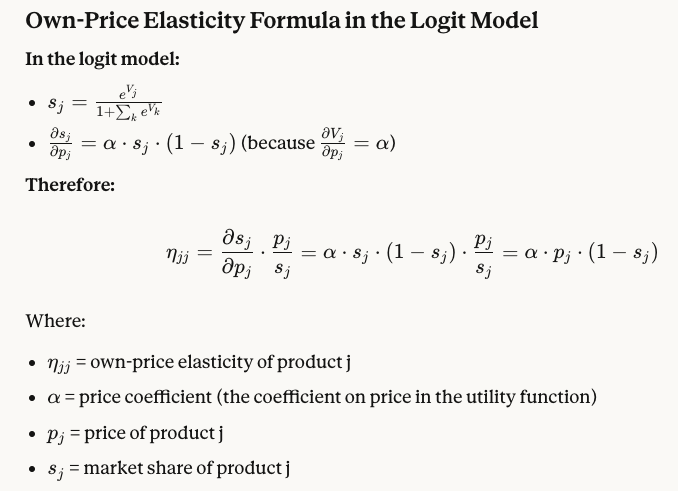

In [9]:
display(Image(filename="/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/2.3.png"))

In [10]:
# Step 1: get the prices coefficient [alpha]
alpha = results_logit.beta[1]  # prices coefficient
print(f"Price coefficient (alpha): {alpha}")

# Step 2: get Dr. Pepper's price [P] and market share [s]

# find the row for Dr. Pepper in market 0
m0 = df[df['market_ids'] == 0]
dr_pepper_row = m0[m0['product_name'] == 'Dr Pepper']

p_dr_pepper = dr_pepper_row['prices'].values[0]  # get the price value
s_dr_pepper = dr_pepper_row['shares'].values[0]  # get the market share value

print(f"\nDr. Pepper in Market 0:")
print(f"Price: ${p_dr_pepper}")
print(f"Market Share: {s_dr_pepper}")

Price coefficient (alpha): [-29.06996021]

Dr. Pepper in Market 0:
Price: $1.98
Market Share: 0.0215761465016707


In [11]:
# Step 3: compute own-price elasticity for Dr. Pepper
# els_own = alpha * P * (1 - s)
els_own = alpha * p_dr_pepper * (1 - s_dr_pepper)

print(f"\nOwn-price elasticity of Dr. Pepper (computed by hand): {els_own}")


Own-price elasticity of Dr. Pepper (computed by hand): [-56.31663012]


The own-prics of Dr. Pepper is -56.3166, which is consistent with the result from pyblp.

### (d) Which product has the lowest (in absolute value) own-price elasticity? Why do you think that this? (Hint: Examine the formula for own-price elasticity.)

From (b), we know that the product with the lowest own-price elasticity is Diet Coke

In [12]:
# 只需要简单验证你的观察
# find the row for Dr. Pepper
DietCoke_row = m0[m0['product_name'] == 'Diet Coke']

p_DietCoke = DietCoke_row['prices'].values[0]
s_DietCoke = DietCoke_row['shares'].values[0]

print(f"\nDiet Coke has the lowest own-price elasticity in Market 0:")
print(f"Price: ${p_DietCoke}")
print(f"Market Share: {s_DietCoke}")


print(f"\n(1 - s_j): {1 - s_DietCoke}")


Diet Coke has the lowest own-price elasticity in Market 0:
Price: $1.47
Market Share: 0.1076186878803011

(1 - s_j): 0.8923813121196988


Formula: |η_jj| = |α| · p_j · (1 - s_j)

1) Diet Coke has a highest market share, which makes (1 - s_j) very small, 

2) Diet Coke has the lowest price.
   
Which esulting in the lowest elasticity.

### (e) Compare the cross price elasticity of 7-Up with respect to Dr. Pepper and the cross price elasticity of 7-Up with respect to Diet 7-Up. Which is larger? Explain the difference.

In [13]:
eta_7up_drpepper = elasticities_logit.loc['7UP', 'Dr Pepper']

print(f"cross price elasticity of 7-Up with respect to Dr. Pepper:")
print(eta_7up_drpepper)

eta_7up_Diet7Up = elasticities_logit.loc['7UP', 'Diet 7UP']
print(f"\ncross price elasticity of 7-Up with respect to Diet 7Up:")
print(eta_7up_Diet7Up)

cross price elasticity of 7-Up with respect to Dr. Pepper:
1.241891086046137

cross price elasticity of 7-Up with respect to Diet 7Up:
2.5166039532065625


Cross price elasticity of 7Up with respect to Diet 7Up is larger.

Since this two products are more similar (both are 7Up brand). Considering customer's preference, if the price of Diet 7Up increases, customers who prefer 7Up brand are more likely to switch to 7Up instead of Dr. Pepper.

### (f) Explain mathematically why the cross price elasticities in each column of the matrix are equal.

elasticities[i, j] = η_ij：

When the price of product j (column j) changes by 1%,
         the demand for product i (row i) changes by η_ij %

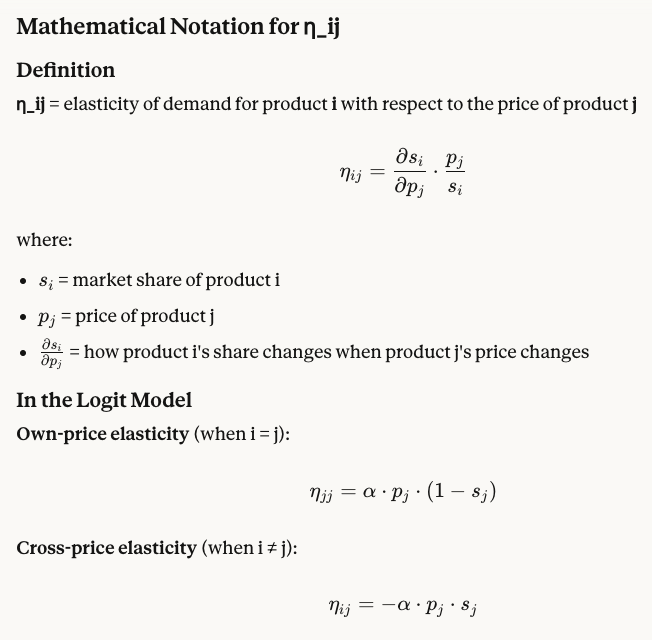

In [14]:
display(Image(filename="/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/2.4.png"))

The formula η_ij = -α · p_j · s_j depends ONLY on:

  - α (constant across all products)
  
  - p_j (product j's (column) characteristics)
  
  - s_j (product j's (column) characteristics)
  
It does not depend on i (row, the product whose demand changes)

Therefore, for a fixed column j, ALL cross-elasticities are equal:
    
  - η_1j = -α · p_j · s_j

  - η_2j = -α · p_j · s_j  
    ...

  - η_ij = -α · p_j · s_j  for all i ≠ j

Thus: All entries in column j (except the diagonal) are similar/identical.

##  4. Nested Logit
### (a) Create a variable nesting_ids which is 1 if the soda is Diet and 0 otherwise.

In [15]:
# Nested Logit
product_nest1 = df.copy()
product_nest1['product_diet'] = (product_nest1['sugar'].eq(0)).astype(int)

# .eq(0) is the function to check if sugar is 0 (Diet)
# .astype(int) converts the boolean result (True/False) to integer (1/0)
product_nest1['nesting_ids'] = product_nest1['product_diet'] 

### (b) Estimate a nested logit model of demand using the nesting ids from part a. (Hint: You may need to try different initial values for ρ to achieve convergence.)

In [16]:
groups = product_nest1.groupby(['market_ids','nesting_ids'])
product_nest1['demand_instruments3'] = groups['sugar'].transform(np.size) # number of products in each nest within each market

nl_formulation = pyblp.Formulation('1 + prices + sugar + caffeine + brand_CocaCola + brand_PepsiCo')

problem = pyblp.Problem(nl_formulation, product_nest1)

nl_results = problem.solve(rho = 0.7)    # rho is the within-nest correlation, we used rammda in the chalss.

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N    K1    MD    H 
---  ---  ----  ----  ---
52   504   6     9     2 

Formulations:
     Column Indices:         0     1       2       3               4                     5         
--------------------------  ---  ------  -----  --------  --------------------  -------------------
X1: Linear Characteristics   1   prices  sugar  caffeine  brand_CocaCola[True]  brand_PepsiCo[True]
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...



GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1     00:00:00         0             1            0            0          0     +1.731262E+00                 +4.521221E-02  +7.000000E-01
 1     00:00:00         0             2            0            0          0     +1.773455E+00                 +1.911643E+00  +6.547878E-01
 1     00:00:00         0             3            0            0          0     +1.731239E+00  +2.361449E-05  +1.162707E-09  +6.989554E-01

Optimization completed after 00:00:01.
Computing the Hessian and updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
G

### (c) What is your estimate for the nesting parameter? Is it statistically significant at level α = .1?

In [17]:
rho = 0.7103
se = 0.2695
t_stat = rho / se
print(f"rho = {rho}")
print(f"t value = {t_stat}")

print(f"\nCritical value (α=0.1): 1.645")

if abs(t_stat) > 1.645:
    print("\nRho IS statistically significant at α = 0.1")
else:
    print("\nRho is NOT significant at α = 0.1")

rho = 0.7103
t value = 2.635621521335807

Critical value (α=0.1): 1.645

Rho IS statistically significant at α = 0.1


## 5. Analyzing Nested Logit Demand Elasticities
### (a) Calculate the demand elasticity matrix for market 0 (i.e., the market with a market_id of 0).


In [18]:
elasticities_nl = nl_results.compute_elasticities(market_id=0)

# name
elasticities_nl = pd.DataFrame(elasticities_nl, index=names, columns=names)

print(elasticities_nl.shape)

# print the first 11 x 11  block of the elasticity matrix
print("\nReview the Logit Elasticities (first left side 11 X 5 block):")
print(elasticities_logit.iloc[:11, :5])

print("\nNow we get the Nested Logit Elasticities (first left side 11x5 block):")
print(elasticities_nl.iloc[:11, :5])

Computing elasticities with respect to prices ...
Finished after 00:00:00.

(11, 11)

Review the Logit Elasticities (first left side 11 X 5 block):
               Dr Pepper  A&W Root Beer       Coke     Sprite  Pepsi Max
Dr Pepper     -56.316630       0.747665   1.152407   0.769686   3.975964
A&W Root Beer   1.241891     -60.589952   1.152407   0.769686   3.975964
Coke            1.241891       0.747665 -56.406114   0.769686   3.975964
Sprite          1.241891       0.747665   1.152407 -60.567930   3.975964
Pepsi Max       1.241891       0.747665   1.152407   0.769686 -40.791775
Diet 7UP        1.241891       0.747665   1.152407   0.769686   3.975964
Diet Coke       1.241891       0.747665   1.152407   0.769686   3.975964
Coke Zero       1.241891       0.747665   1.152407   0.769686   3.975964
Diet Pepsi      1.241891       0.747665   1.152407   0.769686   3.975964
Pepsi           1.241891       0.747665   1.152407   0.769686   3.975964
7UP             1.241891       0.747665   1.15240


### (b) 1. Do the cross price elasticities now differ within each column of the matrix?

YES. Unlike Simple Logit where all cross-elasticities in a column were identical (all 1.24), Nested Logit shows different values.


### (b) 2.Are they the same within each nest?

In [19]:
# 直接用names就够了
nests = (m0["sugar"].eq(0)).astype(int)
# nests = [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1] # Diet:1 Regular:0
elasticities_nl = pd.DataFrame(elasticities_nl, index=names, columns=names)

# 单独显示nest信息
print("\nNest structure:")
for name, nest in zip(names, nests):
    print(f"{name:20s}: {'Diet' if nest == 1 else 'Regular'}")


Nest structure:
Dr Pepper           : Regular
A&W Root Beer       : Regular
Coke                : Regular
Sprite              : Regular
Pepsi Max           : Diet
Diet 7UP            : Diet
Diet Coke           : Diet
Coke Zero           : Diet
Diet Pepsi          : Diet
Pepsi               : Regular
7UP                 : Regular


Yes, YES. Products within the same nest have same cross-elasticities.

Now: Nested Logit corrects the unrealistic assumption of Simple Logit.

1. Products within the same nest are stronger substitutes
   
2. Products across different nests are weaker substitutes

In other words: In reality, people who prefer sugared sodas and those who prefer diet sodas are indeed different consumer groups, which is intuitively reasonable.

Therefore, Nested Logit is more realistic than Simple Logit.



### (c) What is consumer surplus in market 0?


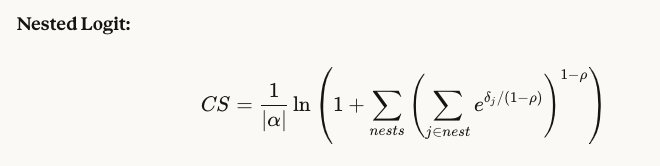

In [20]:
display(Image(filename="/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/2.5.png"))

In [21]:
# we can simply use the pyblp function to get consumer surplus
cs_nl = nl_results.compute_consumer_surpluses(market_id=0)

print(f"Consumer Surplus in Market 0 (Nested Logit): {cs_nl}")

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

Consumer Surplus in Market 0 (Nested Logit): [[0.05311872]]



### (d) What is the percentage change in consumer surplus in market 0 from a 1% increase in the price of all products?


In [ ]:
# price increase by 1%
m0_price_increase = m0.copy()
m0_price_increase['prices'] = m0_price_increase['prices'] * 1.01  # increase prices by 1%

# calculate new cs
cs_nl_new = nl_results.compute_consumer_surpluses(market_id=0, prices = m0_price_increase['prices'])

print(f"New Consumer Surplus in Market 0 after 1% price increase (Nested Logit): {cs_nl_new}")

print(f"Percentage change in Consumer Surplus: {(cs_nl_new - cs_nl) / cs_nl * 100}%")

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

New Consumer Surplus in Market 0 after 1% price increase (Nested Logit): [[0.04528931]]
Percentage change in Consumer Surplus: [[-14.73945366]]%
